In [0]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [0]:
# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-12 04:31:27--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy.2’

mnist_test_seq.npy. 100%[===================>] 781.25M  16.5MB/s    in 50s     

2020-05-12 04:32:18 (15.5 MB/s) - ‘mnist_test_seq.npy.2’ saved [819200096/819200096]



In [0]:
# Useful libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

In [0]:
# Data processing
data = np.load('mnist_test_seq.npy')
data = data.swapaxes(0, 1) # swap frames and instances for tf handling
data = data[:500, :, :, :] # reduce memory and compute requirements by selecting a subsample
data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
data = data/np.amax(data) # normalize between 0 and 1 (min-max scaling)
data = tf.cast(data, tf.float32) # convert to float32 for tf handling
N, F, H, W, C = data.shape # dims
print('dataset = '+str(data.shape)) # shape is [instance x frame x height x width x channel]

dataset = (500, 20, 64, 64, 1)


In [0]:
# Create Input/output dataset: 
# previous frame (X_t-1) is used as input to predict next frame (y_t)
def shift_data(data, cutoff):
  N = data.shape[1]
  X = data[:, :cutoff, :, :, :]
  y = data[:, 1:cutoff+1, :, :, :]
  return X, y
init_traj = 10
X, y = shift_data(data, init_traj)
print("X is:", X.shape)
print("y is:", y.shape)

X is: (500, 10, 64, 64, 1)
y is: (500, 10, 64, 64, 1)


In [0]:
# Our Model Architecture
def model_init():
    inputs = tf.keras.Input(shape=[None, H, W, C])
    # Encoder
    CL1, cl1_h, cl1_c = tf.keras.layers.ConvLSTM2D(64, 3, 
                                     padding='same', kernel_initializer='he_normal',
                                     return_sequences=True, return_state=True)(inputs)
    CL2, cl2_h, cl2_c = tf.keras.layers.ConvLSTM2D(64, 3, 
                                     padding='same', kernel_initializer='he_normal',
                                     return_sequences=True, return_state=True)(CL1)
    # Decoder
    CL3 = tf.keras.layers.ConvLSTM2D(64, 3, 
                                     padding='same', kernel_initializer='he_normal',
                                     return_sequences=True)(CL1, initial_state=[cl1_h, cl1_c])
    concat1 = tf.keras.layers.Concatenate()([CL2, CL3])
    CL4 = tf.keras.layers.ConvLSTM2D(64, 3, 
                                     padding='same', kernel_initializer='he_normal',
                                     return_sequences=True)(concat1, initial_state=[cl2_h, cl2_c])
    # Prediction
    concat2 = tf.keras.layers.Concatenate()([CL3, CL4])
    preds = tf.keras.layers.Conv3D(1, 1, 
                                   activation='sigmoid', 
                                   padding='same', kernel_initializer='he_normal')(concat2)
    return tf.keras.Model(inputs=inputs, outputs=preds)

In [0]:
# Custom metrics: SSIM, PSNR, POD, FAR

def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def POD(y_gt, y_pred):
  y_gt_pos = tf.math.greater(y_gt, 0)
  y_pred_pos = tf.math.greater(y_pred, 0)
  y_pred_neg = tf.math.logical_not(y_pred_pos)
  y_gt_pos = tf.cast(y_gt_pos, tf.float32)
  y_pred_pos = tf.cast(y_pred_pos, tf.float32)
  y_pred_neg = tf.cast(y_pred_neg, tf.float32)
  hits = tf.keras.backend.sum(y_gt_pos * y_pred_pos)
  misses = tf.keras.backend.sum(y_gt_pos * y_pred_neg)
  return hits/(hits+misses)

def FAR(y_gt, y_pred):
  y_gt_pos = tf.math.greater(y_gt, 0)
  y_pred_pos = tf.math.greater(y_pred, 0)
  y_gt_neg = tf.math.logical_not(y_gt_pos)
  y_gt_pos = tf.cast(y_gt_pos, tf.float32)
  y_pred_pos = tf.cast(y_pred_pos, tf.float32)
  y_gt_neg = tf.cast(y_gt_neg, tf.float32)
  hits = tf.keras.backend.sum(y_gt_pos * y_pred_pos)
  falsealarms = tf.keras.backend.sum(y_gt_neg * y_pred_pos)
  return falsealarms/(hits+falsealarms)

def CSI(y_gt, y_pred):
  y_gt_pos = tf.math.greater(y_gt, 0)
  y_pred_pos = tf.math.greater(y_pred, 0)
  y_pred_neg = tf.math.logical_not(y_pred_pos)
  y_gt_neg = tf.math.logical_not(y_gt_pos)
  y_gt_pos = tf.cast(y_gt_pos, tf.float32)
  y_pred_pos = tf.cast(y_pred_pos, tf.float32)
  y_gt_neg = tf.cast(y_gt_neg, tf.float32)
  y_pred_neg = tf.cast(y_pred_neg, tf.float32)
  hits = tf.keras.backend.sum(y_gt_pos * y_pred_pos)
  misses = tf.keras.backend.sum(y_gt_pos * y_pred_neg)
  falsealarms = tf.keras.backend.sum(y_gt_neg * y_pred_pos)
  return hits/(hits+misses+falsealarms)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)



# Custom Loss

def ssim_loss(y_gt, y_pred, max_val=1.):
  return 1-tf.math.reduce_mean(tf.image.ssim(y_gt, y_pred, max_val))

def mse_mae_ssim_loss(y_gt, y_pred, max_val=1.):
  return ssim_loss(y_gt, y_pred, max_val) + \
         tf.keras.losses.MSE(y_gt, y_pred) + \
         tf.keras.losses.MAE(y_gt, y_pred)

In [0]:
# Initialize model
model = model_init()
# Build optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mse',
              metrics=['acc', ssim, psnr, POD, FAR, CSI, cor])
# Fit the model
history = model.fit(X, y, batch_size=10, epochs=30, validation_split=0.1)

Epoch 1/30
45/45 [==============================] - 111s 2s/step - loss: 0.0465 - acc: 0.9157 - ssim: 0.3224 - psnr: 14.8954 - POD: 1.0000 - FAR: 0.9285 - CSI: 0.0715 - cor: 0.4522 - val_loss: 0.0188 - val_acc: 0.9287 - val_ssim: 0.5347 - val_psnr: 17.4575 - val_POD: 1.0000 - val_FAR: 0.9316 - val_CSI: 0.0684 - val_cor: 0.7148
Epoch 2/30
45/45 [==============================] - 110s 2s/step - loss: 0.0164 - acc: 0.9253 - ssim: 0.6083 - psnr: 18.1387 - POD: 1.0000 - FAR: 0.9285 - CSI: 0.0715 - cor: 0.7765 - val_loss: 0.0132 - val_acc: 0.9325 - val_ssim: 0.6888 - val_psnr: 19.1326 - val_POD: 1.0000 - val_FAR: 0.9316 - val_CSI: 0.0684 - val_cor: 0.8258
Epoch 3/30
45/45 [==============================] - 110s 2s/step - loss: 0.0114 - acc: 0.9275 - ssim: 0.7234 - psnr: 19.9170 - POD: 1.0000 - FAR: 0.9285 - CSI: 0.0715 - cor: 0.8538 - val_loss: 0.0102 - val_acc: 0.9315 - val_ssim: 0.7824 - val_psnr: 20.6464 - val_POD: 1.0000 - val_FAR: 0.9316 - val_CSI: 0.0684 - val_cor: 0.8573
Epoch 4/30
45

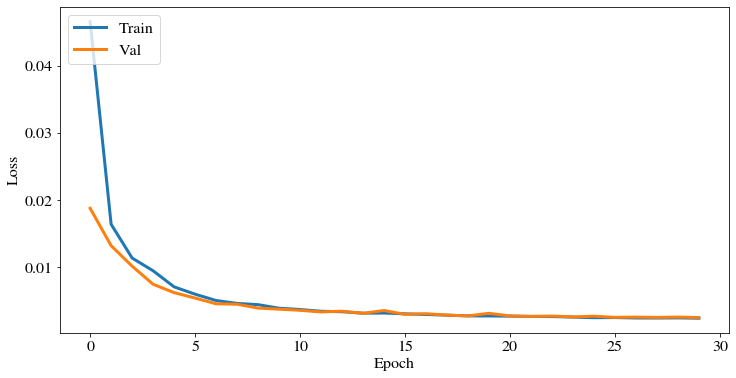

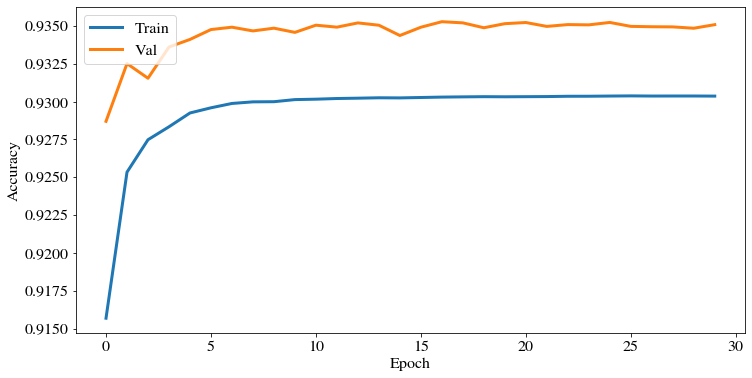

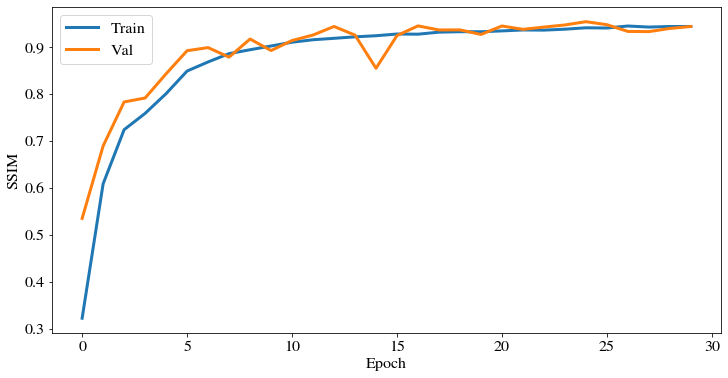

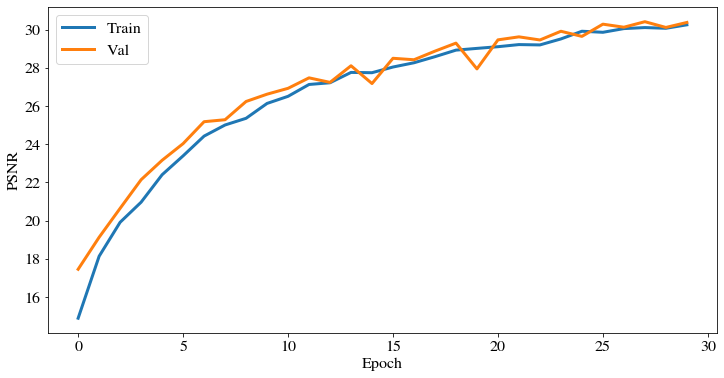

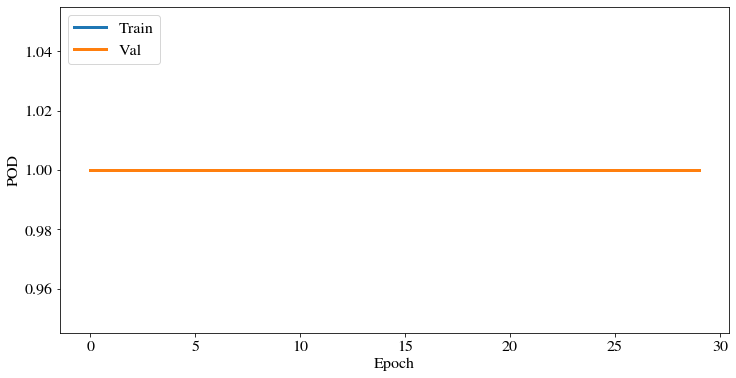

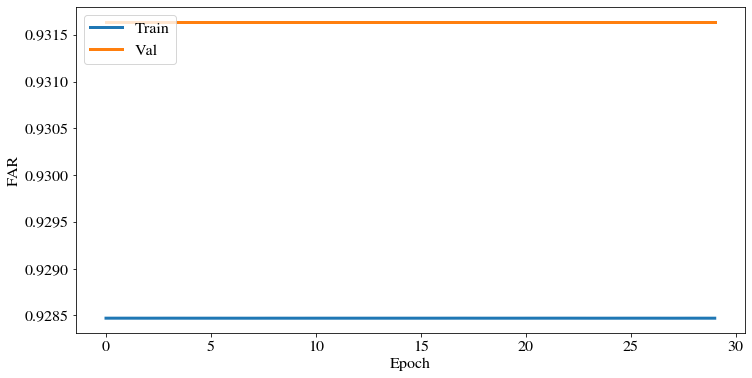

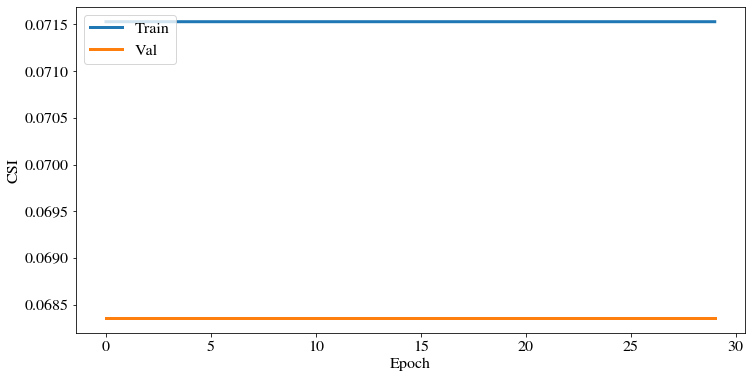

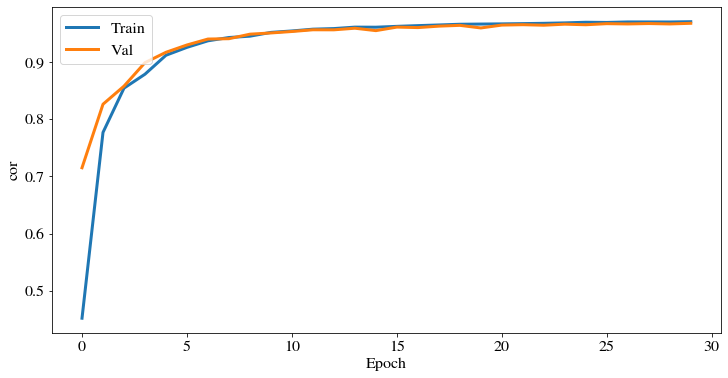

In [0]:
# loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
#files.download('loss.png')

# accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('accuracy.png')
#files.download('accuracy.png')

# ssim
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
#files.download('ssim.png')

# psnr
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
#files.download('psnr.png')

# pod
plt.figure(figsize=(12,6))
plt.plot(history.history['POD'], label='Train')
plt.plot(history.history['val_POD'], label='Val')
plt.ylabel('POD')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('pod.png')
#files.download('pod.png')

# far
plt.figure(figsize=(12,6))
plt.plot(history.history['FAR'], label='Train')
plt.plot(history.history['val_FAR'], label='Val')
plt.ylabel('FAR')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('far.png')
#files.download('far.png')

# csi
plt.figure(figsize=(12,6))
plt.plot(history.history['CSI'], label='Train')
plt.plot(history.history['val_CSI'], label='Val')
plt.ylabel('CSI')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('csi.png')
#files.download('csi.png')

# cor
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.ylabel('cor')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
#files.download('cor.png')

In [0]:
# Select a random observation, initial trajectory and predicted trajectory
itest = 50
pred_traj = 5
track = X[itest, :, :, :, :]
for i in range(pred_traj):
  new_pos = model.predict(track[None, :, :, :, :])
  track = np.concatenate((track, new_pos[:, -1, :, :, :]), axis=0)
print("track:", track.shape)

track: (15, 64, 64, 1)


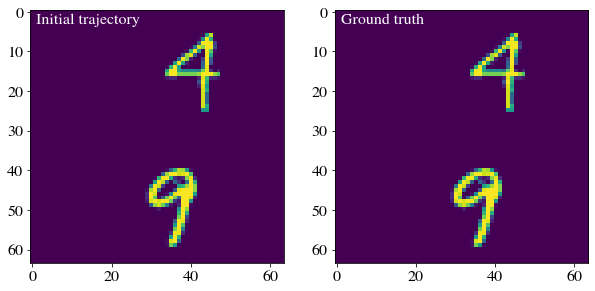

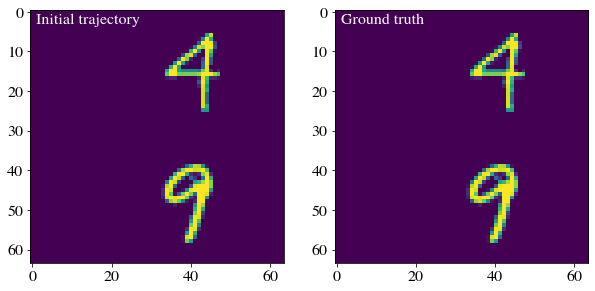

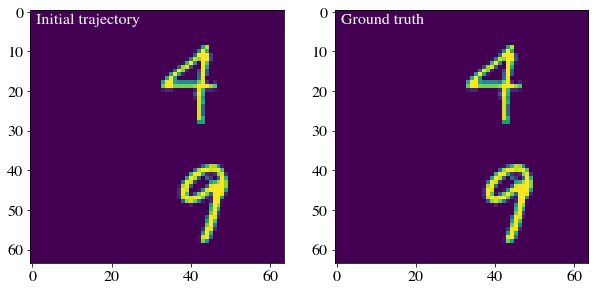

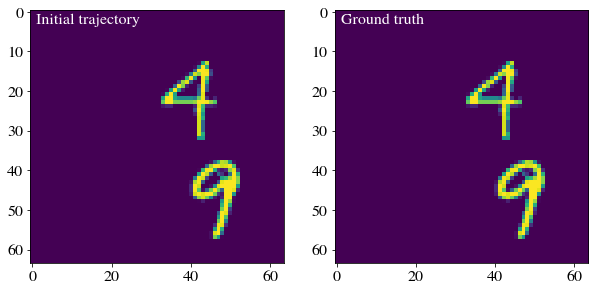

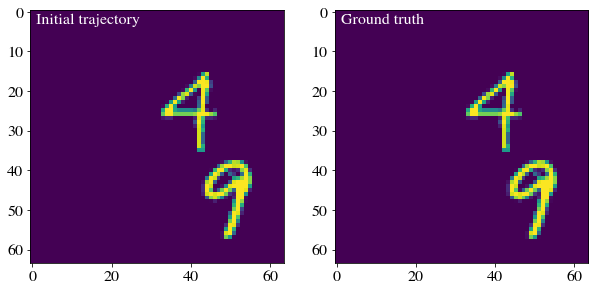

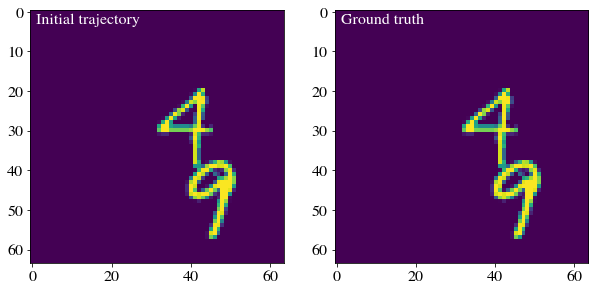

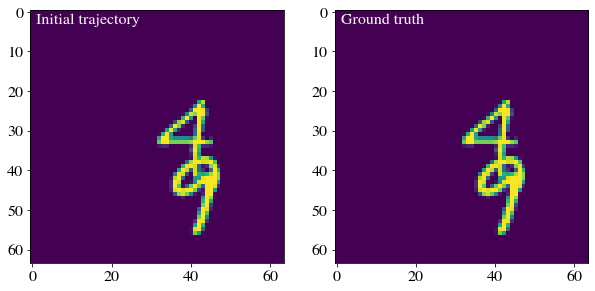

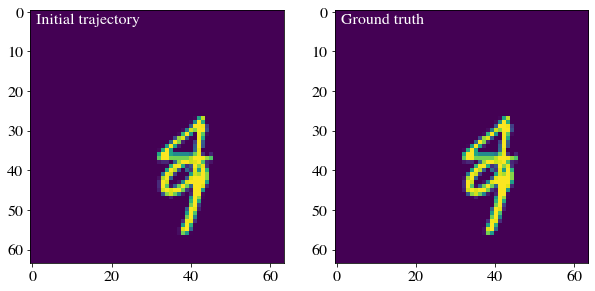

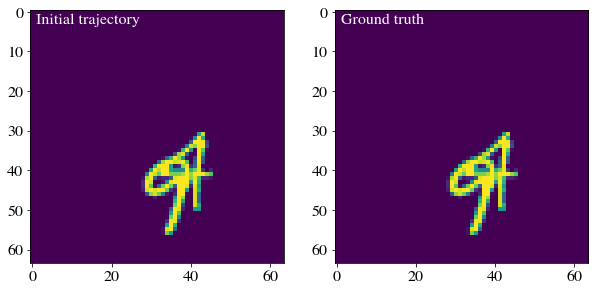

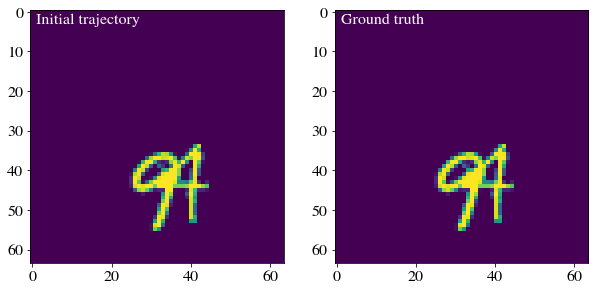

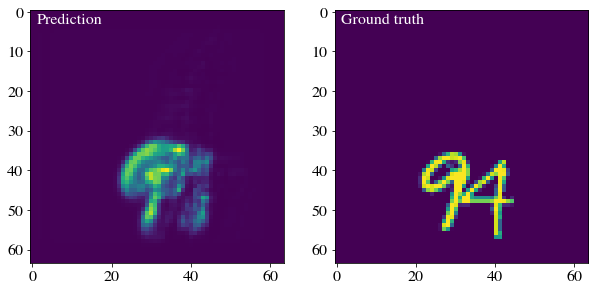

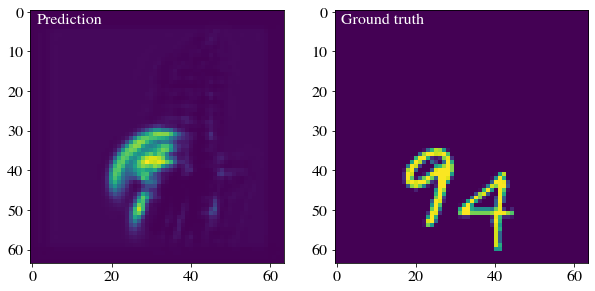

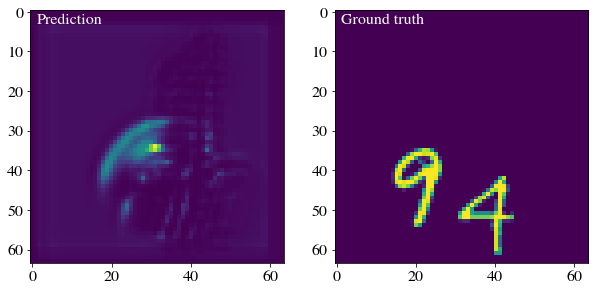

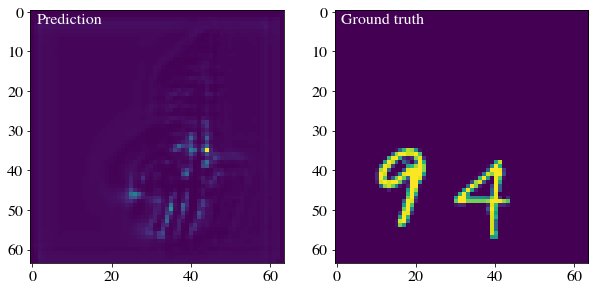

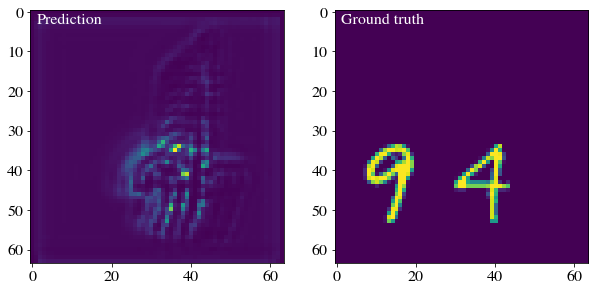

In [0]:
# Plot results
true_track = data[itest, :, :, :, 0]

for i in range(init_traj+pred_traj):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    if i >= init_traj:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])

    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :])

    #files.download('anim_%i.png' % (i+1))